In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [12]:
# 前処理をするための関数を用意

# 全ての部屋をLDKの形に直す
def identify_floor_plan(floor_plan):
    if floor_plan.find('ワンルーム') > -1:
        floor_plan = '1K'
    if floor_plan.find('+') > -1:
        floor_plan = floor_plan[:floor_plan.find("+")]
        
    return floor_plan
        
#　沿線情報の修正と分割
def get_line_station(line_station):
    
    # J RをJRに変換
    if line_station.find('JR') > -1:
        line_station = line_station.replace('J R', 'JR')
    
    #バスと徒歩の時間の取得
    if line_station.find('バス') > -1:
        bus_time_text = re.search(r'バス(\d+)分', line_station)
        bus_time = bus_time_text.group(1)
        
        if line_station.find('停歩') > -1:
            walk_time_text = re.search(r'停歩(\d+)分', line_station)
            walk_time = walk_time_text.group(1)
        else:
            walk_time_text = re.search(r'歩(\d+)分', line_station)
            walk_time = walk_time_text.group(1)

    else:
        bus_time = 0
        walk_time_text = re.search(r'徒歩(\d+)分', line_station)
        walk_time = walk_time_text.group(1)
        
    #沿線と駅名の取得
    line = line_station[ : line_station.find('「')]
    
    station = line_station[line_station.find('「') + 1 : line_station.find('」')]
    
    return line, station, bus_time, walk_time


def get_page_count(hit_count):
    # ヒット件数の数値のみ取得
    hit_count = hit_count.strip()
    hit_count = hit_count.replace(',', '')
    hit_count = hit_count.replace('件', '')
    
    # ページの計算
    page_count = divmod(int(hit_count) , 30)
    if page_count[1] == 0:
        page_count = page_count[0]
    else:
        page_count = page_count[0] + 1
    
    return page_count

In [13]:
# 23区都心部のURL(千代田区、中央区、港区、新宿区、文京区、渋谷区)
# 23区東部(台東区、墨田区、江東区、荒川区、足立区、葛飾区、江戸川区)
# 23区南部(品川区、目黒区、大田区、世田谷区)
# 23区西部(中野区、杉並区、練馬区)
# 23区北部(豊島区、北区、板橋区)

url_list = ['https://suumo.jp/jj/bukken/ichiran/JJ010FJ001/?ar=030&bs=011&ta=13&jspIdFlg=patternShikugun&sc=13101&sc=13102&sc=13103&sc=13104&sc=13105&sc=13113&kb=1&kt=9999999&mb=0&mt=9999999&ekTjCd=&ekTjNm=&tj=0&cnb=0&cn=9999999&srch_navi=1&page={}',
            'https://suumo.jp/jj/bukken/ichiran/JJ010FJ001/?ar=030&bs=011&ta=13&jspIdFlg=patternShikugun&sc=13106&sc=13107&sc=13108&sc=13118&sc=13121&sc=13122&sc=13123&kb=1&kt=9999999&mb=0&mt=9999999&ekTjCd=&ekTjNm=&tj=0&cnb=0&cn=9999999&srch_navi=1&page={}',
            'https://suumo.jp/jj/bukken/ichiran/JJ010FJ001/?ar=030&bs=011&ta=13&jspIdFlg=patternShikugun&sc=13109&sc=13110&sc=13111&sc=13112&kb=1&kt=9999999&mb=0&mt=9999999&ekTjCd=&ekTjNm=&tj=0&cnb=0&cn=9999999&srch_navi=1&page={}',
            'https://suumo.jp/jj/bukken/ichiran/JJ010FJ001/?ar=030&bs=011&ta=13&jspIdFlg=patternShikugun&sc=13114&sc=13115&sc=13120&kb=1&kt=9999999&mb=0&mt=9999999&ekTjCd=&ekTjNm=&tj=0&cnb=0&cn=9999999&srch_navi=1&page={}',
            'https://suumo.jp/jj/bukken/ichiran/JJ010FJ001/?ar=030&bs=011&ta=13&jspIdFlg=patternShikugun&sc=13116&sc=13117&sc=13119&kb=1&kt=9999999&mb=0&mt=9999999&ekTjCd=&ekTjNm=&tj=0&cnb=0&cn=9999999&srch_navi=1&page={}']

# 5つのエリアごとに収納するリストを作成
urls = [''] * 5

for i, url_base in enumerate(url_list):
    url = url_base.format(1)    # 1ページ目の取得
    r = requests.get(url)
    soup = BeautifulSoup(r.text)

    # 検索ヒット件数の取得
    hit_count = soup.find('div', class_='pagination_set-hit').text
    r.close()

    # ページ数を取得
    
    # 各urlのページ数計算
    
    page_count = get_page_count(hit_count)
    
    """
    別方法
    
    body = soup.find('body')
    pages = body.find('ol', {'class': 'pagination-parts'}) # ページのナビタグを取得
    pages_text = str(pages)                                    # 文字列に変換
    pages_split0 = pages_text.split('</a></li>\n</ol>')
    pages_split1 = pages_split0[0]
    pages_split2 = pages_split1[-3:]                           #後ろから3文字(ページ数)を取得
    pages_split = int(pages_split2)                            #整数に変換

    """

    #URLを入れるリスト
    urls[i] = []
    #1ページ目を格納
    urls[i].append(url)

    #2ページ目以降を格納
    for j in range(page_count - 1):
        page_num = j + 2
        url_page = url_base.format(page_num)
        urls[i].append(url_page)
        
        

In [14]:
#取得する特徴量
cols = ['price', 'name', 'address', 'ward', 'line_station', 'line', 'station','bus_time',
        'walk_time', 'area', 'balcony', 'floor_plan', 'age', 'renovation', 'reform']

# 5つのテーブルデータを作成するためのリスト作成
df = [''] * 5

for i in range(5):
    
    df[i] = pd.DataFrame(index=[], columns=cols)
    data = {}
    
    for url in urls[i]:
        r = requests.get(url)
        soup = BeautifulSoup(r.text)
        r.close
        contents = soup.find_all('div', 'property_unit-content')

        for content in contents:
            details = content.find_all('dl')

            #物件名
            data['name'] = details[0].find('dd').text

            #販売価格
            data['price'] = details[1].find('span').text

            #所在地：住所と区を取り出す
            address = details[2].find('dd').text
            data['address'] = address
            data['ward'] = address.replace('東京都', '').split('区')[0] + '区'

            #沿線・駅：沿線、駅名、徒歩時間、バス時間を取り出す
            line_station = details[3].find('dd').text
            data['line_station'] = line_station

            line, station, bus_time, walk_time = get_line_station(line_station)

            data['line'] = line
            data['station'] = station
            data['bus_time'] = bus_time
            data['walk_time'] = walk_time

            #専有面積
            data['area'] = details[4].find('dd').text

            #間取り
            floor_plan = details[5].find('dd').text
            floor_plan = identify_floor_plan(floor_plan)
            data['floor_plan'] = floor_plan

            #バルコニー
            data['balcony'] = details[6].find('dd').text

            #築年数
            data['age'] = details[7].find('dd').text

            #リノベーション・リフォーム情報の取得
            header = content.find('h2').text

            #リノベーション：ヘッダーに「リノベ」の文字列があるときにFlagとして持つ
            if header.find('リノベ') > -1:
                data['renovation'] = 1
            else:
                data['renovation'] = 0

            #リフォーム：ヘッダーに「リフォーム」の文字列があるときにFlagとして持つ
            if header.find('リフォーム') > -1:
                data['reform'] = 1
            else:
                data['reform'] = 0

            if len(data) >=1:
                df[i] = df[i].append(data, ignore_index=True)
                data = {}

        #スクレイピング時のマナーとして、プログラムを停止する
        time.sleep(1)

    # CSVファイルの出力
        file_name = './property_data_' + str(i) + '.csv'
        df[i].to_csv(f'./{file_name}', index=False)

/var/folders/6p/x2syvpfd3vz5q63zs_8g3ny40000gn/T/ipykernel_18946/1552134495.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df[i] = df[i].append(data, ignore_index=True)
/var/folders/6p/x2syvpfd3vz5q63zs_8g3ny40000gn/T/ipykernel_18946/1552134495.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df[i] = df[i].append(data, ignore_index=True)
/var/folders/6p/x2syvpfd3vz5q63zs_8g3ny40000gn/T/ipykernel_18946/1552134495.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df[i] = df[i].append(data, ignore_index=True)
/var/folders/6p/x2syvpfd3vz5q63zs_8g3ny40000gn/T/ipykernel_18946/1552134495.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

AttributeError: 'NoneType' object has no attribute 'group'

In [2]:
#保存したcsvファイルを読み込み
df0 = pd.read_csv('./property_data_0.csv')
df1 = pd.read_csv('./property_data_1.csv')
df2 = pd.read_csv('./property_data_2.csv')
df3 = pd.read_csv('./property_data_3.csv')
df4 = pd.read_csv('./property_data_4.csv')

#分割していたファイルを結合
df = pd.concat([df0, df1, df2, df3, df4], axis = 0, ignore_index=True)

In [3]:
# データの前処理

# 価格の統一を行う関数を作成
def convert_price(price):
    # 万円 権利権を含むの処理
    if price.find("※") > -1:
        price = price[:price.find('※')]
    
    # ○○万円 ~ ○○万円の処理
    if price.find('〜') > -1:
        price = price[price.find('〜') + 1 : ]
        
        if price.find('億') > -1:
            # 1億円ジャストのような場合の処理
            if price.find('万') == -1:
                price = int(price[:price.find('億')]) * 10000
            # 1億 ○○万円のとき
            else:
                oku = int(price[:price.find('億')]) * 10000
                price = oku + int(price[price.find('億') + 1 : -2])
        else:
            price = int(price[:price.find('万')])
    else:
        if price.find('億') > -1:
            # 1億円ジャストのような場合の処理
            if price.find('万') == -1:
                price = int(price[:price.find('億')]) * 10000
            # 1億 ○○万円のとき
            else:
                oku = int(price[:price.find('億')]) * 10000
                price = oku + int(price[price.find('億') + 1 : -2])
        else:
            price = int(price[:price.find('万')])
        
    return price

In [4]:
# 前処理

# 価格の表示を数値のみで表現
for i, price in enumerate(df['price']):
    df.loc[i,'price'] = convert_price(price)

In [5]:
for i, area in enumerate(df['area']):
    if area.find('m') > -1:
        df.loc[i, 'area'] = float(area[:area.find('m')])
    elif area.find('㎡') > -1:
        df.loc[i, 'area'] = float(area[:area.find('㎡')])
    else:
        print(i)

In [6]:
for i, balcony in enumerate(df['balcony']):
    if re.search(r'\d+', balcony):
        if balcony.find('m') > -1:
            df.loc[i, 'balcony'] = float(balcony[:balcony.find('m')])
        elif balcony.find('㎡'):
            df.loc[i, 'balcony'] = float(balcony[:balcony.find('㎡')])
        else:
            print(i)
    else:
        df.loc[i, 'balcony'] = float(0)

In [7]:
for i, age in enumerate(df['age']):
    df.loc[i, 'age'] = 2022 - int(age[:age.find('年')])

In [8]:
fix_walk_time = df['line_station']

for i, wt in enumerate(fix_walk_time):
    if wt.find('停歩') > -1 & df.iloc[i].isnull().any():
        walk_time_text = re.search(r'停歩(\d+)分', wt)
        walk_time = walk_time_text.group(1)
        df.iloc[i,8] = int(walk_time)

In [9]:
df = df.astype({'price': 'int32', 'area': 'float32', 'balcony': 'float32', 'age': 'int8', 'walk_time': 'int64'})

In [10]:
df.shape[0] - df.count()

price           0
name            0
address         0
ward            0
line_station    0
line            0
station         0
bus_time        0
walk_time       0
area            0
balcony         0
floor_plan      0
age             0
renovation      0
reform          0
dtype: int64

In [11]:
df.head()

,price,name,address,ward,line_station,line,station,bus_time,walk_time,area,balcony,floor_plan,age,renovation,reform
0,1680,パレ・ドール日本橋Ⅱ・SOHO可・リフォーム完成！,東京都中央区日本橋小舟町,中央区,都営浅草線「人形町」徒歩5分,都営浅草線,人形町,0,5,21.200001,3.90,1K,41,0,1
1,1680,サンパレス新宿,東京都新宿区西新宿８,新宿区,東京メトロ丸ノ内線「西新宿」徒歩2分,東京メトロ丸ノ内線,西新宿,0,2,18.850000,2.40,1K,41,0,0
2,1690,ダイアパレス幡ヶ谷,東京都渋谷区幡ヶ谷２,渋谷区,京王線「笹塚」徒歩6分,京王線,笹塚,0,6,21.000000,2.15,1K,38,0,0
3,2480,シャンボール文京,東京都文京区千石２-１９－４,文京区,都営三田線「千石」徒歩10分,都営三田線,千石,0,10,27.299999,3.90,1DK,51,1,0
4,2480,朝日関口マンション,東京都文京区関口１-24-6,文京区,東京メトロ有楽町線「江戸川橋」徒歩3分,東京メトロ有楽町線,江戸川橋,0,3,28.580000,2.30,1DK,40,0,0


In [12]:
df.describe()

,price,bus_time,walk_time,area,balcony,age,renovation,reform
count,19206.000000,19206.000000,19206.000000,19206.000000,19206.000000,19206.000000,19206.000000,19206.000000
mean,6263.858690,0.034208,6.719306,58.074535,7.415180,29.921379,0.112257,0.054827
std,5589.908486,0.668187,3.915615,21.751764,8.551726,15.494550,0.315690,0.227647
min,550.000000,0.000000,1.000000,11.250000,0.000000,-120.000000,0.000000,0.000000
25%,3380.000000,0.000000,4.000000,43.200001,3.992500,17.000000,0.000000,0.000000
50%,4898.000000,0.000000,6.000000,56.330002,6.340000,31.000000,0.000000,0.000000
75%,7480.000000,0.000000,9.000000,69.589996,9.400000,43.000000,0.000000,0.000000
max,198000.000000,23.000000,87.000000,366.190002,586.729980,66.000000,1.000000,1.000000


In [13]:
df.info() #19206件

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19206 entries, 0 to 19205
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         19206 non-null  int32  
 1   name          19206 non-null  object 
 2   address       19206 non-null  object 
 3   ward          19206 non-null  object 
 4   line_station  19206 non-null  object 
 5   line          19206 non-null  object 
 6   station       19206 non-null  object 
 7   bus_time      19206 non-null  int64  
 8   walk_time     19206 non-null  int64  
 9   area          19206 non-null  float32
 10  balcony       19206 non-null  float32
 11  floor_plan    19206 non-null  object 
 12  age           19206 non-null  int8   
 13  renovation    19206 non-null  int64  
 14  reform        19206 non-null  int64  
dtypes: float32(2), int32(1), int64(4), int8(1), object(7)
memory usage: 1.9+ MB


In [14]:
# 重複データの削除(複数の不動産会社が同じ物件を掲載しているため)
df = df.drop_duplicates(ignore_index = True)
df.info() #16455件

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16455 entries, 0 to 16454
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         16455 non-null  int32  
 1   name          16455 non-null  object 
 2   address       16455 non-null  object 
 3   ward          16455 non-null  object 
 4   line_station  16455 non-null  object 
 5   line          16455 non-null  object 
 6   station       16455 non-null  object 
 7   bus_time      16455 non-null  int64  
 8   walk_time     16455 non-null  int64  
 9   area          16455 non-null  float32
 10  balcony       16455 non-null  float32
 11  floor_plan    16455 non-null  object 
 12  age           16455 non-null  int8   
 13  renovation    16455 non-null  int64  
 14  reform        16455 non-null  int64  
dtypes: float32(2), int32(1), int64(4), int8(1), object(7)
memory usage: 1.6+ MB


In [424]:
df.loc[df['balcony'].idxmax()]

price                            8980
name            オープンレジデンシア神楽坂ウエスト・テラス
address                     東京都新宿区納戸町
ward                              新宿区
line_station        都営大江戸線「牛込神楽坂」徒歩7分
line                           都営大江戸線
station                         牛込神楽坂
bus_time                            0
walk_time                         7.0
area                        72.389999
balcony                     586.72998
floor_plan                       3LDK
age                                 4
renovation                          0
reform                              0
Name: 467, dtype: object

In [429]:
df.loc[df['walk_time'].idxmax()]

price                     4699
name                   桜台ハイライズ
address             東京都練馬区豊玉上２
ward                       練馬区
line_station    西武池袋線「桜台」徒歩87分
line                     西武池袋線
station                     桜台
bus_time                     0
walk_time                   87
area                 68.419998
balcony                    5.1
floor_plan                3LDK
age                         49
renovation                   0
reform                       0
Name: 14679, dtype: object

In [15]:
# 5億円以下のマンションに限定
df = df[df['price'] <= 20000]

In [439]:
df.sort_values('walk_time', ascending=False).head(n = 10)

,price,name,address,ward,line_station,line,station,bus_time,walk_time,area,balcony,floor_plan,age,renovation,reform
12569,4699,桜台ハイライズ,東京都練馬区豊玉上２,練馬区,西武池袋線「桜台」徒歩87分,西武池袋線,桜台,0,87,68.419998,5.100000,3LDK,49,0,0
7230,2149,エステート花畑第弐号棟,東京都足立区花畑６-12-2,足立区,東武伊勢崎線「谷塚」徒歩31分,東武伊勢崎線,谷塚,0,31,79.290001,10.840000,3LDK,40,0,0
7350,2380,信和江戸川マンション,東京都江戸川区中央２-１８－１９,江戸川区,ＪＲ総武線「新小岩」徒歩27分,ＪＲ総武線,新小岩,0,27,59.200001,20.389999,3LDK,48,1,0
12021,8980,グランスイート岡本,東京都世田谷区岡本３,世田谷区,東急田園都市線「用賀」徒歩27分,東急田園都市線,用賀,0,27,81.209999,10.800000,3LDK,16,0,0
6079,3790,グリーンコーポ江戸川親水公園 ６階,東京都江戸川区松島１,江戸川区,ＪＲ総武線「新小岩」徒歩26分,ＪＲ総武線,新小岩,0,26,77.250000,24.610001,3LDK,39,1,0
7163,1980,グリーンパーク新綾瀬,東京都足立区辰沼２,足立区,東京メトロ千代田線「北綾瀬」徒歩26分,東京メトロ千代田線,北綾瀬,0,26,60.200001,9.500000,3LDK,34,0,0
7228,2130,グレイスコート竹ノ塚,東京都足立区南花畑５-1-5,足立区,つくばエクスプレス「六町」徒歩25分,つくばエクスプレス,六町,0,25,67.830002,12.200000,3LDK,31,0,0
7089,1580,グリーンパーク水元４リバーサイド,東京都葛飾区南水元２,葛飾区,東京メトロ千代田線「北綾瀬」徒歩25分,東京メトロ千代田線,北綾瀬,0,25,50.770000,7.920000,2LDK,35,0,0
5910,2690,日商岩井第二新小岩マンションA棟,東京都江戸川区中央２-１７－１８,江戸川区,ＪＲ総武線快速「新小岩」徒歩24分,ＪＲ総武線快速,新小岩,0,24,59.000000,7.420000,3LDK,47,1,0
8981,8980,グランスイート岡本,東京都世田谷区岡本３,世田谷区,東急田園都市線「用賀」徒歩24分,東急田園都市線,用賀,0,24,81.209999,10.800000,3LDK,16,0,0


In [440]:
df.sort_values('balcony', ascending=False).head(n = 10)

,price,name,address,ward,line_station,line,station,bus_time,walk_time,area,balcony,floor_plan,age,renovation,reform
462,8980,オープンレジデンシア神楽坂ウエスト・テラス,東京都新宿区納戸町,新宿区,都営大江戸線「牛込神楽坂」徒歩7分,都営大江戸線,牛込神楽坂,0,7,72.389999,586.729980,3LDK,4,0,0
2733,4680,秀和田町レジデンス,東京都港区芝浦２,港区,ＪＲ山手線「田町」徒歩9分,ＪＲ山手線,田町,0,9,44.500000,470.000000,1LDK,40,0,0
9317,2298,中銀第３目黒マンション,東京都品川区西五反田４,品川区,東急目黒線「不動前」徒歩5分,東急目黒線,不動前,0,5,29.260000,378.000000,1LDK,41,0,0
16377,8980,サンビューハイツ駒込,東京都豊島区駒込４,豊島区,ＪＲ山手線「巣鴨」徒歩5分,ＪＲ山手線,巣鴨,0,5,101.570000,128.179993,3LDK,41,0,0
12398,17800,クレードルパレス柿の木坂,東京都目黒区柿の木坂１-20-17,目黒区,東急東横線「都立大学」徒歩8分,東急東横線,都立大学,0,8,179.899994,88.209999,3LDK,37,0,0
10978,5499,大森海岸パ－クハウス,東京都大田区大森本町１,大田区,京急本線「大森海岸」徒歩8分,京急本線,大森海岸,0,8,71.320000,71.320000,3LDK,38,0,0
3616,6499,グランドパレス田町,東京都港区芝浦４-9-18,港区,ＪＲ京浜東北線「田町」徒歩9分,ＪＲ京浜東北線,田町,0,9,70.470001,70.470001,2LDK,41,0,0
10755,4980,経堂ペアシティ,東京都世田谷区経堂４-26-14,世田谷区,小田急線「千歳船橋」徒歩9分,小田急線,千歳船橋,0,9,68.639999,67.570000,3LDK,49,0,0
14485,11980,パークハイム浜田山ヴィプレジール,東京都杉並区浜田山３,杉並区,京王井の頭線「浜田山」徒歩5分,京王井の頭線,浜田山,0,5,107.029999,66.230003,3LDK,20,0,0
14484,11980,パークハイム浜田山ヴィプレジール,東京都杉並区浜田山３,杉並区,京王井の頭線「浜田山」徒歩5分,京王井の頭線,浜田山,0,5,107.059998,66.230003,3LDK,20,0,0


In [16]:
# 徒歩時間の補正　※SUUMOホームページを確認して補正
df.loc[12569, 'walk_time'] = 7
df.loc[7230, 'walk_time'] = 23

# バルコニーの外れ値の補正　※SUUMOホームページを確認して補正
df.loc[8980, 'walk_time'] = 24
df.loc[462, 'balcony'] = 29.58
df.loc[2733, 'balcony'] = 4.7


In [17]:
#　バルコニーの外れ値を調べた時に出てきた重複を削除(文字変換が異なっていて 'drop_duplicates'で消せていなかった)
target = df.query("name == '中銀第３目黒マンション'").index
df = df.drop(target)

In [18]:
df.describe()

,price,bus_time,walk_time,area,balcony,age,renovation,reform
count,16135.000000,16135.000000,16135.000000,16135.000000,16135.000000,16135.000000,16135.000000,16135.000000
mean,5681.764239,0.040719,6.817973,56.502094,7.199904,30.237310,0.120793,0.061357
std,3430.982226,0.728829,3.915261,19.586027,5.864436,15.500557,0.325897,0.239992
min,550.000000,0.000000,1.000000,11.250000,0.000000,-120.000000,0.000000,0.000000
25%,3280.000000,0.000000,4.000000,42.360001,3.890000,18.000000,0.000000,0.000000
50%,4780.000000,0.000000,6.000000,55.680000,6.260000,32.000000,0.000000,0.000000
75%,7094.000000,0.000000,9.000000,68.419998,9.300000,43.000000,0.000000,0.000000
max,20000.000000,23.000000,27.000000,212.410004,128.179993,66.000000,1.000000,1.000000


In [36]:
df.sort_values('age').head(n=10)

,price,name,address,ward,line_station,line,station,bus_time,walk_time,area,balcony,floor_plan,age,renovation,reform
15634,3800,キャニオンマンション志村城山公園,東京都板橋区志村３,板橋区,都営三田線「志村三丁目」徒歩1分,都営三田線,志村三丁目,0,1,53.810001,6.40,2LDK,-120,0,0
14754,8980,ブリリアシティ西早稲田,東京都豊島区高田１,豊島区,東京メトロ副都心線「雑司が谷」徒歩8分,東京メトロ副都心線,雑司が谷,0,8,72.160004,12.40,3LDK,0,0,0
12401,17980,ザ・パークハウス自由が丘ディアナガーデン,東京都目黒区自由が丘３,目黒区,東急東横線「自由が丘」徒歩9分,東急東横線,自由が丘,0,9,90.529999,13.20,3LDK,0,0,0
12400,17980,ザ・パークハウス自由ヶ丘ディアナガーデン,東京都目黒区自由が丘３,目黒区,東急東横線「自由が丘」徒歩9分,東急東横線,自由が丘,0,9,90.529999,13.20,3LDK,0,0,0
3317,5880,ルジェンテ新宿御苑前,東京都新宿区新宿５,新宿区,東京メトロ丸ノ内線「新宿御苑前」徒歩7分,東京メトロ丸ノ内線,新宿御苑前,0,7,33.540001,6.81,1LDK,0,0,0
11451,6580,世田谷喜多見ザ・テラス,東京都世田谷区喜多見９-１１－９,世田谷区,小田急線「喜多見」徒歩3分,小田急線,喜多見,0,3,59.529999,7.03,1LDK,0,0,0
12366,14980,ザ・パークハウス自由ヶ丘ディアナガーデン,東京都目黒区自由が丘３,目黒区,東急東横線「自由が丘」徒歩9分,東急東横線,自由が丘,0,9,81.080002,0.00,1LDK,0,0,0
12365,14980,ザ・パークハウス自由が丘ディアナガーデン,東京都目黒区自由が丘３,目黒区,東急東横線「自由が丘」徒歩9分,東急東横線,自由が丘,0,9,81.080002,20.74,1LDK,0,0,0
16331,7490,ヴェレーナグラン赤羽北フロント,東京都北区赤羽北２,北区,ＪＲ埼京線「北赤羽」徒歩3分,ＪＲ埼京線,北赤羽,0,3,71.309998,0.00,2LDK,0,0,0
11404,6480,ピアース大森山王3丁目,東京都大田区山王３-28-17,大田区,ＪＲ京浜東北線「大森」徒歩6分,ＪＲ京浜東北線,大森,0,6,45.750000,7.61,1LDK,0,0,0


In [37]:
# 築年数の外れ値を補正　※SUUMOホームページを確認して補正
df.loc[15634, 'age'] = 36

In [28]:
import geopandas as gpd
gdf = gpd.read_file('./S12-21_GML/utf8/S12-21_NumberOfPassengers.shp')
gdf.head()

,geometry
0,"LINESTRING (130.63035 31.25405, 130.62985 31.2..."
1,"LINESTRING (127.70279 26.23035, 127.70309 26.2..."
2,"LINESTRING (139.77818 35.62961, 139.77888 35.6..."
3,"LINESTRING (139.77335 35.62129, 139.77288 35.6..."
4,"LINESTRING (139.78001 35.61791, 139.77932 35.6..."


In [40]:
df.head()

,price,name,address,ward,line_station,line,station,bus_time,walk_time,area,balcony,floor_plan,age,renovation,reform
0,1680,パレ・ドール日本橋Ⅱ・SOHO可・リフォーム完成！,東京都中央区日本橋小舟町,中央区,都営浅草線「人形町」徒歩5分,都営浅草線,人形町,0,5,21.200001,3.90,1K,41,0,1
1,1680,サンパレス新宿,東京都新宿区西新宿８,新宿区,東京メトロ丸ノ内線「西新宿」徒歩2分,東京メトロ丸ノ内線,西新宿,0,2,18.850000,2.40,1K,41,0,0
2,1690,ダイアパレス幡ヶ谷,東京都渋谷区幡ヶ谷２,渋谷区,京王線「笹塚」徒歩6分,京王線,笹塚,0,6,21.000000,2.15,1K,38,0,0
3,2480,シャンボール文京,東京都文京区千石２-１９－４,文京区,都営三田線「千石」徒歩10分,都営三田線,千石,0,10,27.299999,3.90,1DK,51,1,0
4,2480,朝日関口マンション,東京都文京区関口１-24-6,文京区,東京メトロ有楽町線「江戸川橋」徒歩3分,東京メトロ有楽町線,江戸川橋,0,3,28.580000,2.30,1DK,40,0,0


In [54]:
df.to_csv('property_data_processed.csv', index=False)

/Users/sho.t/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


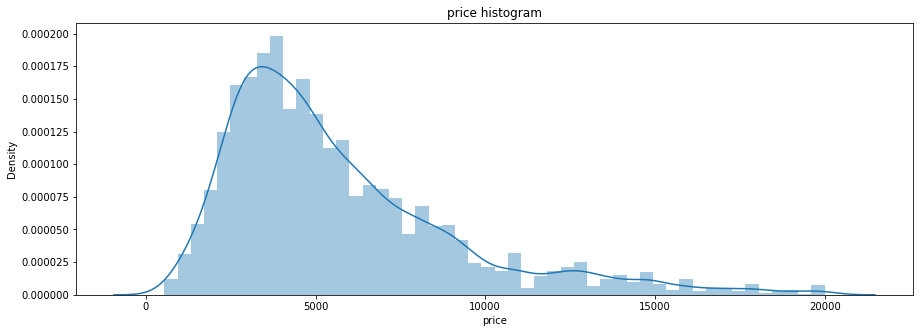

In [32]:
plt.figure(figsize= (15,5))
plt.title('price histogram')
sns.distplot(df['price'])
plt.show()

3000~4000万円の物件が多い

/Users/sho.t/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


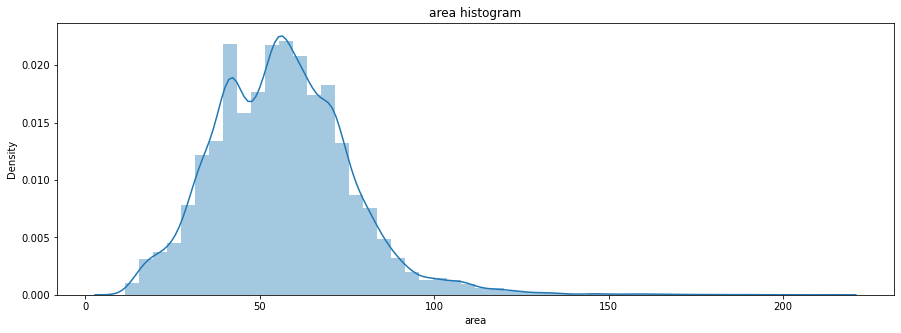

In [33]:
plt.figure(figsize = (15,5))
plt.title('area histogram')
sns.distplot(df['area'])
plt.show()

50~60㎡の物件が多い

/Users/sho.t/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


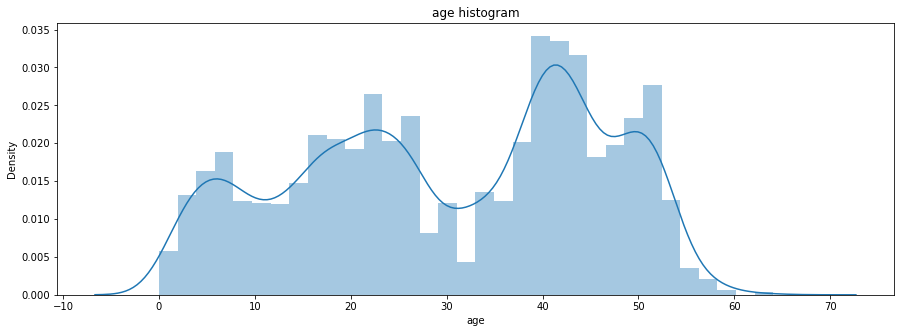

In [38]:
plt.figure(figsize = (15,5))
plt.title('age histogram')
sns.distplot(df['age'])
plt.show()

築25年〜35年の物件の数が少ない

1990年代の物件のためバブル崩壊後の不動産の不人気が影響していそう

<AxesSubplot:title={'center':'the number of sales by ward'}, xlabel='count', ylabel='ward'>

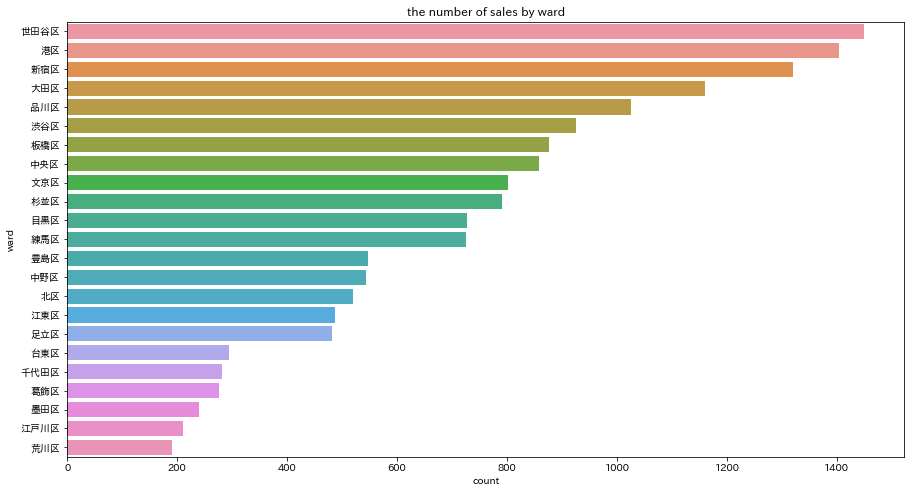

In [52]:
#　区の名前を日本語表示
import japanize_matplotlib
japanize_matplotlib.japanize()

# 区ごとの物件販売数をヒストグラムで可視化
plt.figure(figsize = (15,8))
plt.title('the number of sales by ward')
sns.countplot(y='ward', data=df, order=df['ward'].value_counts().index)

In [43]:
df = pd.read_csv('property_data_processed.csv')

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16135 entries, 0 to 16134
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         16135 non-null  int64  
 1   name          16135 non-null  object 
 2   address       16135 non-null  object 
 3   ward          16135 non-null  object 
 4   line_station  16135 non-null  object 
 5   line          16135 non-null  object 
 6   station       16135 non-null  object 
 7   bus_time      16135 non-null  int64  
 8   walk_time     16135 non-null  int64  
 9   area          16135 non-null  float64
 10  balcony       16135 non-null  float64
 11  floor_plan    16135 non-null  object 
 12  age           16135 non-null  int64  
 13  renovation    16135 non-null  int64  
 14  reform        16135 non-null  int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 1.8+ MB


In [37]:
g_data = pd.read_excel('./日本市町村ポリゴン2016-08-12.xlsx', sheet_name=[0,1])
g_data[1].head()

,LocalID,都道府県,振興局等、支庁,市郡,区町村,面積
0,1000,北海道,,,,83424.31
1,1100,北海道,石狩振興局,札幌市,,1121.26
2,1202,北海道,渡島総合振興局,函館市,,677.86
3,1203,北海道,後志総合振興局,小樽市,,243.83
4,1204,北海道,上川総合振興局,旭川市,,747.66


In [114]:
g_ward_data = g_data[1].query("都道府県 == '東京都' & 市郡.str.match('.*区$')", engine='python')
g_ward_data.head()

,LocalID,都道府県,振興局等、支庁,市郡,区町村,面積
640,13101,東京都,,千代田区,,11.66
641,13102,東京都,,中央区,,10.21
642,13103,東京都,,港区,,20.37
643,13104,東京都,,新宿区,,18.22
644,13105,東京都,,文京区,,11.29


In [115]:
g_ward_data = g_ward_data[['LocalID', '市郡']]
g_ward_data.head()

,LocalID,市郡
640,13101,千代田区
641,13102,中央区
642,13103,港区
643,13104,新宿区
644,13105,文京区


In [116]:
df_group_ward = df.groupby('ward').mean()

In [117]:
df_group_ward['count'] = df.groupby('ward').size()

In [119]:
df_group_ward.reset_index(inplace=True)

In [120]:
df_group_ward.head()

,ward,price,bus_time,walk_time,area,balcony,age,renovation,reform,count
0,世田谷区,5755.258621,0.117931,8.484828,61.437807,7.360386,32.897931,0.103448,0.055172,1450
1,中央区,7114.268917,0.000000,5.160652,55.166065,6.989907,20.782305,0.083818,0.031432,859
2,中野区,4766.170956,0.000000,6.086397,52.806691,6.258474,32.181985,0.134191,0.069853,544
3,北区,4499.227360,0.030829,6.643545,57.666243,7.631021,27.096339,0.105973,0.050096,519
4,千代田区,9024.120567,0.000000,3.787234,54.781596,6.999645,23.943262,0.049645,0.049645,282


In [121]:
df_group_ward = pd.merge(g_ward_data, df_group_ward, left_on='市郡', right_on='ward', how='inner').drop(columns='市郡')

In [123]:
df_group_ward.to_csv('ward_data.csv')

In [122]:
df_group_ward.head()

,LocalID,ward,price,bus_time,walk_time,area,balcony,age,renovation,reform,count
0,13101,千代田区,9024.120567,0.0,3.787234,54.781596,6.999645,23.943262,0.049645,0.049645,282
1,13102,中央区,7114.268917,0.0,5.160652,55.166065,6.989907,20.782305,0.083818,0.031432,859
2,13103,港区,8719.738604,0.0,6.757835,56.900028,7.133860,26.242877,0.086895,0.051994,1404
3,13104,新宿区,5832.503788,0.0,5.456818,52.654371,6.249303,30.753030,0.130303,0.065909,1320
4,13105,文京区,6301.362047,0.0,5.639201,55.655144,6.645993,28.408240,0.118602,0.071161,801
